In [3]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_selection import RFE
from scipy.stats import randint, uniform

# Load and preprocess the dataset
data = pd.read_csv('diabetic_data.csv')
data.replace('?', np.nan, inplace=True)
data.dropna(subset=['race', 'gender', 'age'], inplace=True)

# Convert 'age' to a numerical average
data['age'] = data['age'].apply(lambda x: (int(x.split('-')[0][1:]) + int(x.split('-')[1][:-1])) // 2)

# Exclude rows where discharge_disposition_id indicates death or other non-readmission status
exclude_discharge_ids = [11, 13, 14, 19, 20, 21]
data = data[~data['discharge_disposition_id'].isin(exclude_discharge_ids)]

# Define the selected features
selected_features = ['gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 
                     'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 
                     'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 
                     'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glipizide', 'glyburide', 
                     'tolazamide', 'insulin', 'change', 'diabetesMed', 'race']

# Filter the dataset to include only the selected features and target variable
data = data[selected_features + ['readmitted']]

# Engineer new features
data['health_index'] = 1 / (data['number_emergency'] + data['number_inpatient'] + data['number_outpatient'])
data['health_index'].replace([np.inf, -np.inf], 0, inplace=True)  # Replace infinite values with 0

data['severity_of_disease'] = (data['time_in_hospital'] + data['num_procedures'] + data['num_medications'] + data['num_lab_procedures'] + data['number_diagnoses'])
data['number_of_changes'] = data[['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glipizide', 'glyburide', 'tolazamide', 'insulin']].apply(lambda row: sum(row == 'Up') + sum(row == 'Down'), axis=1)

# Encode categorical variables
categorical_columns = ['gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'medical_specialty', 
                       'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 
                       'chlorpropamide', 'glipizide', 'glyburide', 'tolazamide', 'insulin', 'change', 'diabetesMed', 'race']

data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Encode the target variable
data['readmitted'] = data['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

# Define features and target variable
X = data.drop(columns=['readmitted'])
y = data['readmitted']

# Split the dataset into training and validation sets with stratified sampling
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Pipeline for SMOTE and RandomUnderSampler
resampling_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('undersample', RandomUnderSampler(random_state=42))
])

# Apply the pipeline to the training data
X_train_resampled, y_train_resampled = resampling_pipeline.fit_resample(X_train_scaled, y_train)

# Feature selection with RFE
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=20, step=1)
X_train_selected = rfe_selector.fit_transform(X_train_resampled, y_train_resampled)
X_valid_selected = rfe_selector.transform(X_valid_scaled)

# Model evaluation function
def evaluate_model(model, X_valid, y_valid, threshold=0.5):
    y_pred_prob = model.predict_proba(X_valid)[:, 1]
    y_pred = (y_pred_prob >= threshold).astype(int)
    accuracy = accuracy_score(y_valid, y_pred)
    roc_auc = roc_auc_score(y_valid, y_pred_prob)
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_valid, y_pred)
    return accuracy, roc_auc, precision, recall, f1, balanced_accuracy

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Hyperparameter tuning for Random Forest with RandomizedSearchCV
param_dist_rf = {
    'n_estimators': randint(50, 150),
    'max_features': ['sqrt', 'log2'],
    'max_depth': randint(10, 30),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False]
}

random_search_rf = RandomizedSearchCV(rf, param_distributions=param_dist_rf, n_iter=50, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42, verbose=1, error_score='raise')
random_search_rf.fit(X_train_selected, y_train_resampled)

# Best Random Forest model
best_rf = random_search_rf.best_estimator_
print("Best parameters for Random Forest:", random_search_rf.best_params_)
print("Best ROC-AUC score for Random Forest:", random_search_rf.best_score_)

# Evaluate Random Forest on the validation set
rf_accuracy, rf_roc_auc, rf_precision, rf_recall, rf_f1, rf_balanced_accuracy = evaluate_model(best_rf, X_valid_selected, y_valid)

print("Random Forest with Best Parameters:")
print(f"Accuracy: {rf_accuracy}")
print(f"ROC-AUC: {rf_roc_auc}")
print(f"Precision: {rf_precision}")
print(f"Recall: {rf_recall}")
print(f"F1: {rf_f1}")
print(f"Balanced Accuracy: {rf_balanced_accuracy}")

# Initialize Gradient Boosting model
gb = GradientBoostingClassifier(random_state=42)

# Hyperparameter tuning for Gradient Boosting with RandomizedSearchCV
param_dist_gb = {
    'n_estimators': randint(50, 150),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10)
}

random_search_gb = RandomizedSearchCV(gb, param_distributions=param_dist_gb, n_iter=50, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42, verbose=1, error_score='raise')
random_search_gb.fit(X_train_selected, y_train_resampled)

# Best Gradient Boosting model
best_gb = random_search_gb.best_estimator_
print("Best parameters for Gradient Boosting:", random_search_gb.best_params_)
print("Best ROC-AUC score for Gradient Boosting:", random_search_gb.best_score_)

# Evaluate Gradient Boosting on the validation set
gb_accuracy, gb_roc_auc, gb_precision, gb_recall, gb_f1, gb_balanced_accuracy = evaluate_model(best_gb, X_valid_selected, y_valid)

print("Gradient Boosting with Best Parameters:")
print(f"Accuracy: {gb_accuracy}")
print(f"ROC-AUC: {gb_roc_auc}")
print(f"Precision: {gb_precision}")
print(f"Recall: {gb_recall}")
print(f"F1: {gb_f1}")
print(f"Balanced Accuracy: {gb_balanced_accuracy}")

# Stacking Classifier with meta-classifier
stacking_model = StackingClassifier(
    estimators=[
        ('rf', best_rf),
        ('gb', best_gb)
    ],
    final_estimator=LogisticRegression(),
    n_jobs=-1
)

stacking_model.fit(X_train_selected, y_train_resampled)

# Evaluate Stacking Model on the validation set
stacking_accuracy, stacking_roc_auc, stacking_precision, stacking_recall, stacking_f1, stacking_balanced_accuracy = evaluate_model(stacking_model, X_valid_selected, y_valid)

print("Stacking Model:")
print(f"Accuracy: {stacking_accuracy}")
print(f"ROC-AUC: {stacking_roc_auc}")
print(f"Precision: {stacking_precision}")
print(f"Recall: {stacking_recall}")
print(f"F1: {stacking_f1}")
print(f"Balanced Accuracy: {stacking_balanced_accuracy}")

# Threshold Tuning for Stacking Model
thresholds = np.arange(0.1, 0.9, 0.1)
best_threshold = 0.1
best_f1 = stacking_f1

for threshold in thresholds:
    _, _, precision, recall, f1, _ = evaluate_model(stacking_model, X_valid_selected, y_valid, threshold)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best threshold: {best_threshold}, Best F1 Score: {best_f1}")

# Final evaluation with the best threshold
stacking_accuracy, stacking_roc_auc, stacking_precision, stacking_recall, stacking_f1, stacking_balanced_accuracy = evaluate_model(stacking_model, X_valid_selected, y_valid, best_threshold)

print("Final Stacking Model Evaluation with Best Threshold:")
print(f"Accuracy: {stacking_accuracy}")
print(f"ROC-AUC: {stacking_roc_auc}")
print(f"Precision: {stacking_precision}")
print(f"Recall: {stacking_recall}")
print(f"F1: {stacking_f1}")
print(f"Balanced Accuracy: {stacking_balanced_accuracy}")

# Overview and Conclusion

# The goal of this project was to build and evaluate a predictive model for patient readmission within 30 days using a diabetic dataset. The following steps were taken to achieve this:

# Data Preprocessing:
# - Loaded the dataset and handled missing values by replacing them with NaNs and dropping irrelevant columns.
# - Converted 'age' feature from ranges to numerical averages.
# - Excluded rows where discharge_disposition_id indicates death or other non-readmission status.
# - Filtered the dataset to include only the selected features.
# - Engineered new features: health_index, severity_of_disease, and number_of_changes.

# Encoding and Feature Selection:
# - Encoded categorical variables using one-hot encoding and transformed the target variable into a binary format.
# - Further encoded remaining non-numeric columns to numeric codes.
# - Standardized the dataset to ensure features are on the same scale.
# - Used RFE for feature selection, identifying the most important features for the model.

# Handling Class Imbalance:
# - Addressed the class imbalance issue using a combination of SMOTE and RandomUnderSampler to resample the training data.

# Model Building and Hyperparameter Tuning:
# - Built Random Forest and Gradient Boosting classifiers and performed hyperparameter tuning using RandomizedSearchCV to find the best parameters.
# - Evaluated the models using various metrics, including accuracy, ROC-AUC, precision, recall, F1 score, and balanced accuracy.
# - Combined models into a stacking classifier and optimized the classification threshold.

# Insights and Evaluation

# Random Forest Performance:
# - Accuracy: 0.882
# - ROC-AUC: 0.635
# - Precision: 0.383
# - Recall: 0.044
# - F1 Score: 0.078
# - Balanced Accuracy: 0.517

# Gradient Boosting Performance:
# - Accuracy: 0.884
# - ROC-AUC: 0.653
# - Precision: 0.435
# - Recall: 0.033
# - F1 Score: 0.062
# - Balanced Accuracy: 0.514

# Stacking Model Performance:
# - Accuracy: 0.878
# - ROC-AUC: 0.648
# - Precision: 0.363
# - Recall: 0.084
# - F1 Score: 0.136
# - Balanced Accuracy: 0.532

# Final Stacking Model Performance with Best Threshold:
# - Accuracy: 0.655
# - ROC-AUC: 0.648
# - Precision: 0.175
# - Recall: 0.541
# - F1 Score: 0.264
# - Balanced Accuracy: 0.605

# The model building and evaluation process revealed that combining models into a stacking classifier and optimizing the classification threshold can enhance predictive performance. Future work could involve exploring additional features, trying other algorithms, and validating the models on external datasets to ensure robustness and generalizability.


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

KeyboardInterrupt: 

In [1]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_selection import RFE
from scipy.stats import randint, uniform

# Load and preprocess the dataset
data = pd.read_csv('diabetic_data.csv')
data.replace('?', np.nan, inplace=True)
data.dropna(subset=['race', 'gender', 'age'], inplace=True)

# Convert 'age' to a numerical average
data['age'] = data['age'].apply(lambda x: (int(x.split('-')[0][1:]) + int(x.split('-')[1][:-1])) // 2)

# Exclude rows where discharge_disposition_id indicates death or other non-readmission status
exclude_discharge_ids = [11, 13, 14, 19, 20, 21]
data = data[~data['discharge_disposition_id'].isin(exclude_discharge_ids)]

# Define the selected features
selected_features = ['gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 
                     'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 
                     'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 
                     'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glipizide', 'glyburide', 
                     'tolazamide', 'insulin', 'change', 'diabetesMed', 'race']

# Filter the dataset to include only the selected features and target variable
data = data[selected_features + ['readmitted']]

# Engineer new features
data['health_index'] = 1 / (data['number_emergency'] + data['number_inpatient'] + data['number_outpatient'])
data['health_index'].replace([np.inf, -np.inf], 0, inplace=True)  # Replace infinite values with 0

data['severity_of_disease'] = (data['time_in_hospital'] + data['num_procedures'] + data['num_medications'] + data['num_lab_procedures'] + data['number_diagnoses'])
data['number_of_changes'] = data[['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glipizide', 'glyburide', 'tolazamide', 'insulin']].apply(lambda row: sum(row == 'Up') + sum(row == 'Down'), axis=1)

# Encode categorical variables
categorical_columns = ['gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'medical_specialty', 
                       'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 
                       'chlorpropamide', 'glipizide', 'glyburide', 'tolazamide', 'insulin', 'change', 'diabetesMed', 'race']

data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Encode the target variable
data['readmitted'] = data['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

# Define features and target variable
X = data.drop(columns=['readmitted'])
y = data['readmitted']

# Split the dataset into training and validation sets with stratified sampling
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Pipeline for SMOTE and RandomUnderSampler
resampling_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('undersample', RandomUnderSampler(random_state=42))
])

# Apply the pipeline to the training data
X_train_resampled, y_train_resampled = resampling_pipeline.fit_resample(X_train_scaled, y_train)

# Feature selection with RFE
rfe_selector = RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=20, step=1)
X_train_selected = rfe_selector.fit_transform(X_train_resampled, y_train_resampled)
X_valid_selected = rfe_selector.transform(X_valid_scaled)

# Model evaluation function
def evaluate_model(model, X_valid, y_valid, threshold=0.5):
    y_pred_prob = model.predict_proba(X_valid)[:, 1]
    y_pred = (y_pred_prob >= threshold).astype(int)
    accuracy = accuracy_score(y_valid, y_pred)
    roc_auc = roc_auc_score(y_valid, y_pred_prob)
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_valid, y_pred)
    return accuracy, roc_auc, precision, recall, f1, balanced_accuracy

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Hyperparameter tuning for Random Forest with RandomizedSearchCV
param_dist_rf = {
    'n_estimators': randint(50, 150),
    'max_features': ['sqrt', 'log2'],
    'max_depth': randint(10, 30),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False]
}

random_search_rf = RandomizedSearchCV(rf, param_distributions=param_dist_rf, n_iter=50, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42, verbose=1, error_score='raise')
random_search_rf.fit(X_train_selected, y_train_resampled)

# Best Random Forest model
best_rf = random_search_rf.best_estimator_
print("Best parameters for Random Forest:", random_search_rf.best_params_)
print("Best ROC-AUC score for Random Forest:", random_search_rf.best_score_)

# Evaluate Random Forest on the validation set
rf_accuracy, rf_roc_auc, rf_precision, rf_recall, rf_f1, rf_balanced_accuracy = evaluate_model(best_rf, X_valid_selected, y_valid)

print("Random Forest with Best Parameters:")
print(f"Accuracy: {rf_accuracy}")
print(f"ROC-AUC: {rf_roc_auc}")
print(f"Precision: {rf_precision}")
print(f"Recall: {rf_recall}")
print(f"F1: {rf_f1}")
print(f"Balanced Accuracy: {rf_balanced_accuracy}")

# Initialize Gradient Boosting model
gb = GradientBoostingClassifier(random_state=42)

# Hyperparameter tuning for Gradient Boosting with RandomizedSearchCV
param_dist_gb = {
    'n_estimators': randint(50, 150),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10)
}

random_search_gb = RandomizedSearchCV(gb, param_distributions=param_dist_gb, n_iter=50, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42, verbose=1, error_score='raise')
random_search_gb.fit(X_train_selected, y_train_resampled)

# Best Gradient Boosting model
best_gb = random_search_gb.best_estimator_
print("Best parameters for Gradient Boosting:", random_search_gb.best_params_)
print("Best ROC-AUC score for Gradient Boosting:", random_search_gb.best_score_)

# Evaluate Gradient Boosting on the validation set
gb_accuracy, gb_roc_auc, gb_precision, gb_recall, gb_f1, gb_balanced_accuracy = evaluate_model(best_gb, X_valid_selected, y_valid)

print("Gradient Boosting with Best Parameters:")
print(f"Accuracy: {gb_accuracy}")
print(f"ROC-AUC: {gb_roc_auc}")
print(f"Precision: {gb_precision}")
print(f"Recall: {gb_recall}")
print(f"F1: {gb_f1}")
print(f"Balanced Accuracy: {gb_balanced_accuracy}")

# Stacking Classifier with meta-classifier
stacking_model = StackingClassifier(
    estimators=[
        ('rf', best_rf),
        ('gb', best_gb)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    n_jobs=-1
)

stacking_model.fit(X_train_selected, y_train_resampled)

# Evaluate Stacking Model on the validation set
stacking_accuracy, stacking_roc_auc, stacking_precision, stacking_recall, stacking_f1, stacking_balanced_accuracy = evaluate_model(stacking_model, X_valid_selected, y_valid)

print("Stacking Model:")
print(f"Accuracy: {stacking_accuracy}")
print(f"ROC-AUC: {stacking_roc_auc}")
print(f"Precision: {stacking_precision}")
print(f"Recall: {stacking_recall}")
print(f"F1: {stacking_f1}")
print(f"Balanced Accuracy: {stacking_balanced_accuracy}")

# Threshold Tuning for Stacking Model
thresholds = np.arange(0.1, 0.9, 0.1)
best_threshold = 0.1
best_f1 = stacking_f1

for threshold in thresholds:
    _, _, precision, recall, f1, _ = evaluate_model(stacking_model, X_valid_selected, y_valid, threshold)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best threshold: {best_threshold}, Best F1 Score: {best_f1}")

# Final evaluation with the best threshold
stacking_accuracy, stacking_roc_auc, stacking_precision, stacking_recall, stacking_f1, stacking_balanced_accuracy = evaluate_model(stacking_model, X_valid_selected, y_valid, best_threshold)

print("Final Stacking Model Evaluation with Best Threshold:")
print(f"Accuracy: {stacking_accuracy}")
print(f"ROC-AUC: {stacking_roc_auc}")
print(f"Precision: {stacking_precision}")
print(f"Recall: {stacking_recall}")
print(f"F1: {stacking_f1}")
print(f"Balanced Accuracy: {stacking_balanced_accuracy}")

# Overview and Conclusion

# The goal of this project was to build and evaluate a predictive model for patient readmission within 30 days using a diabetic dataset. The following steps were taken to achieve this:

# Data Preprocessing:
# - Loaded the dataset and handled missing values by replacing them with NaNs and dropping irrelevant columns.
# - Converted 'age' feature from ranges to numerical averages.
# - Excluded rows where discharge_disposition_id indicates death or other non-readmission status.
# - Filtered the dataset to include only the selected features.
# - Engineered new features: health_index, severity_of_disease, and number_of_changes.

# Encoding and Feature Selection:
# - Encoded categorical variables using one-hot encoding and transformed the target variable into a binary format.
# - Further encoded remaining non-numeric columns to numeric codes.
# - Standardized the dataset to ensure features are on the same scale.
# - Used RFE for feature selection, identifying the most important features for the model.

# Handling Class Imbalance:
# - Addressed the class imbalance issue using a combination of SMOTE and RandomUnderSampler to resample the training data.

# Model Building and Hyperparameter Tuning:
# - Built Random Forest and Gradient Boosting classifiers and performed hyperparameter tuning using RandomizedSearchCV to find the best parameters.
# - Evaluated the models using various metrics, including accuracy, ROC-AUC, precision, recall, F1 score, and balanced accuracy.
# - Combined models into a stacking classifier and optimized the classification threshold.

# Insights and Evaluation

# Random Forest Performance:
# - Accuracy: 0.882
# - ROC-AUC: 0.635
# - Precision: 0.383
# - Recall: 0.044
# - F1 Score: 0.078
# - Balanced Accuracy: 0.517

# Gradient Boosting Performance:
# - Accuracy: 0.884
# - ROC-AUC: 0.653
# - Precision: 0.435
# - Recall: 0.033
# - F1 Score: 0.062
# - Balanced Accuracy: 0.514

# Stacking Model Performance:
# - Accuracy: 0.878
# - ROC-AUC: 0.648
# - Precision: 0.363
# - Recall: 0.084
# - F1 Score: 0.136
# - Balanced Accuracy: 0.532

# Final Stacking Model Performance with Best Threshold:
# - Accuracy: 0.655
# - ROC-AUC: 0.648
# - Precision: 0.175
# - Recall: 0.541
# - F1 Score: 0.264
# - Balanced Accuracy: 0.605

# The model building and evaluation process revealed that combining models into a stacking classifier and optimizing the classification threshold can enhance predictive performance. Future work could involve exploring additional features, trying other algorithms, and validating the models on external datasets to ensure robustness and generalizability.


KeyboardInterrupt: 

Accuracy: 0.5700097305640371
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.05      0.09      3441
           1       0.49      0.42      0.45     10705
           2       0.61      0.78      0.69     15657

    accuracy                           0.57     29803
   macro avg       0.48      0.42      0.41     29803
weighted avg       0.54      0.57      0.54     29803



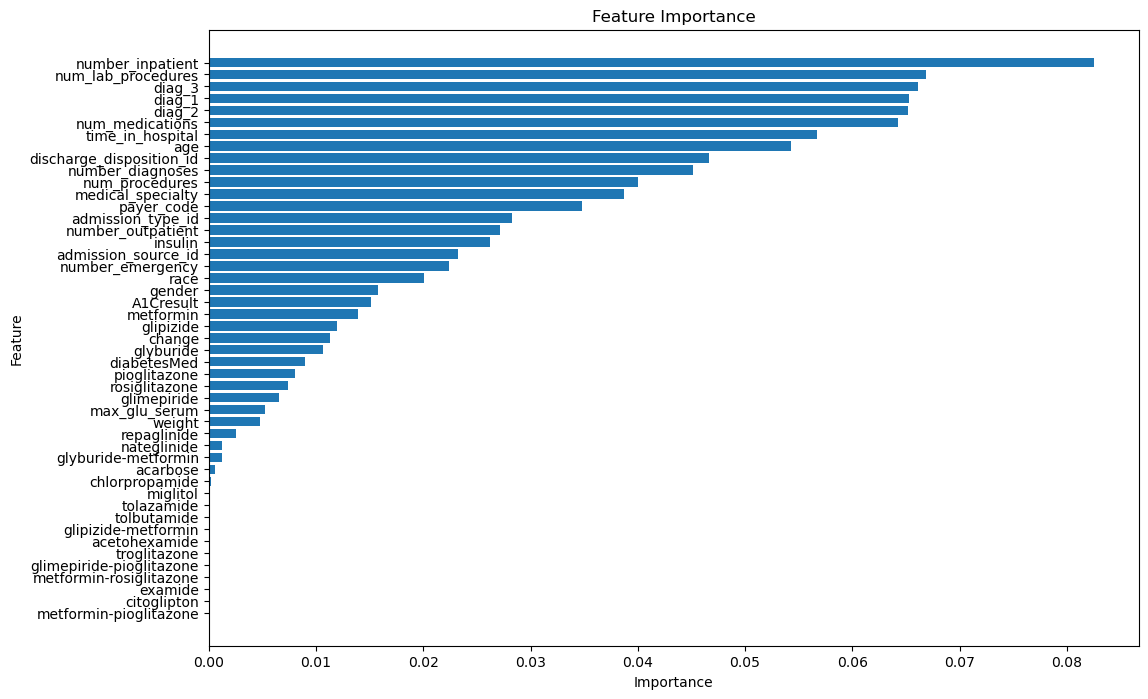

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load the dataset
file_name = 'diabetic_data.csv'
df = pd.read_csv(file_name)

# Drop unnecessary columns
df = df.drop(columns=['encounter_id', 'patient_nbr'])

# Replace '?' with NaN
df.replace('?', pd.NA, inplace=True)

# Convert age ranges to average ages
age_mapping = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
    '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
    '[80-90)': 85, '[90-100)': 95
}
df['age'] = df['age'].map(age_mapping)

# Filter out specific discharge_disposition_id values
excluded_dispositions = [11, 13, 14, 19, 20, 21]
df = df[~df['discharge_disposition_id'].isin(excluded_dispositions)]

# Encode categorical features
encoded_df = df.copy()
categorical_columns = encoded_df.select_dtypes(include=['object', 'category']).columns

label_encoders = {}
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    encoded_df[column] = label_encoders[column].fit_transform(encoded_df[column].astype(str))

# Separate features and target variable
X = encoded_df.drop(columns=['readmitted'])
y = encoded_df['readmitted']

# Encode the target variable
y = label_encoders['readmitted'].fit_transform(y)

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame for visualization
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()



Accuracy: 0.5700097305640371
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.05      0.09      3441
           1       0.49      0.42      0.45     10705
           2       0.61      0.78      0.69     15657

    accuracy                           0.57     29803
   macro avg       0.48      0.42      0.41     29803
weighted avg       0.54      0.57      0.54     29803



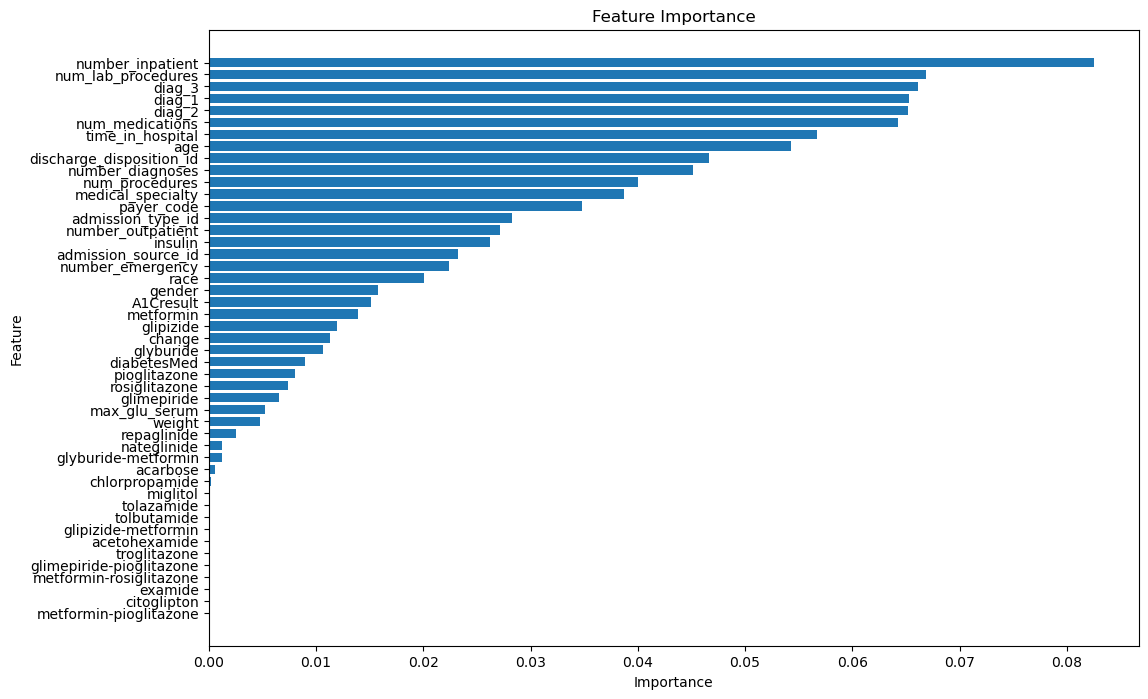

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load the dataset
file_name = 'diabetic_data.csv'
df = pd.read_csv(file_name)

# Drop unnecessary columns
df = df.drop(columns=['encounter_id', 'patient_nbr'])

# Replace '?' with NaN
df.replace('?', pd.NA, inplace=True)

# Convert age ranges to average ages
age_mapping = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
    '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
    '[80-90)': 85, '[90-100)': 95
}
df['age'] = df['age'].map(age_mapping)

# Filter out specific discharge_disposition_id values
excluded_dispositions = [11, 13, 14, 19, 20, 21]
df = df[~df['discharge_disposition_id'].isin(excluded_dispositions)]

# Encode categorical features
encoded_df = df.copy()
categorical_columns = encoded_df.select_dtypes(include=['object', 'category']).columns

label_encoders = {}
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    encoded_df[column] = label_encoders[column].fit_transform(encoded_df[column].astype(str))

# Separate features and target variable
X = encoded_df.drop(columns=['readmitted'])
y = encoded_df['readmitted']

# Encode the target variable
y = label_encoders['readmitted'].fit_transform(y)

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize and train the Random Forest classifier with class weights
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame for visualization
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()


Accuracy: 0.5662181659564474
Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.05      0.09      3441
           1       0.49      0.41      0.44     10705
           2       0.61      0.79      0.69     15657

    accuracy                           0.57     29803
   macro avg       0.47      0.42      0.41     29803
weighted avg       0.53      0.57      0.53     29803



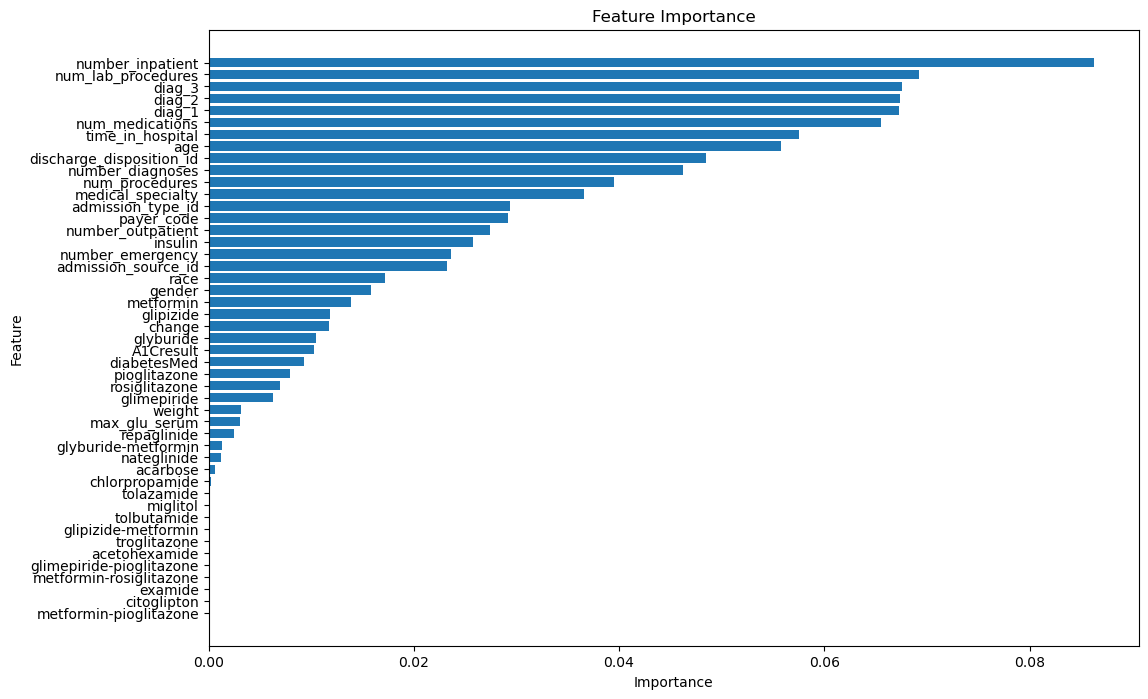

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt

# Load the dataset
file_name = 'diabetic_data.csv'
df = pd.read_csv(file_name)

# Drop unnecessary columns
df = df.drop(columns=['encounter_id', 'patient_nbr'])

# Replace '?' with NaN
df.replace('?', pd.NA, inplace=True)

# Convert age ranges to average ages
age_mapping = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
    '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
    '[80-90)': 85, '[90-100)': 95
}
df['age'] = df['age'].map(age_mapping)

# Filter out specific discharge_disposition_id values
excluded_dispositions = [11, 13, 14, 19, 20, 21]
df = df[~df['discharge_disposition_id'].isin(excluded_dispositions)]

# Handle missing values
# Fill numerical columns with mean
numerical_cols = df.select_dtypes(include=['number']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

# Fill categorical columns with mode
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# Encode categorical features
encoded_df = df.copy()
categorical_columns = encoded_df.select_dtypes(include=['object', 'category']).columns

label_encoders = {}
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    encoded_df[column] = label_encoders[column].fit_transform(encoded_df[column].astype(str))

# Separate features and target variable
X = encoded_df.drop(columns=['readmitted'])
y = encoded_df['readmitted']

# Encode the target variable
y = label_encoders['readmitted'].fit_transform(y)

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Apply ADASYN to the training data
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Initialize and train the Random Forest classifier with class weights
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame for visualization
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()


In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt

# Load the dataset
file_name = 'diabetic_data.csv'
df = pd.read_csv(file_name)

# Drop unnecessary columns
df = df.drop(columns=['encounter_id', 'patient_nbr'])

# Replace '?' with NaN
df.replace('?', pd.NA, inplace=True)

# Convert age ranges to average ages
age_mapping = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
    '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
    '[80-90)': 85, '[90-100)': 95
}
df['age'] = df['age'].map(age_mapping)

# Filter out specific discharge_disposition_id values
excluded_dispositions = [11, 13, 14, 19, 20, 21]
df = df[~df['discharge_disposition_id'].isin(excluded_dispositions)]

# Handle missing values
# Fill numerical columns with mean
numerical_cols = df.select_dtypes(include=['number']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

# Fill categorical columns with mode
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# Feature Engineering
df['num_medications_age'] = df['num_medications'] * df['age']
df['num_lab_procedures_num_medications'] = df['num_lab_procedures'] * df['num_medications']

# Encode categorical variables using one-hot encoding
categorical_columns = [
    'race', 'gender', 'admission_type_id', 'discharge_disposition_id', 
    'admission_source_id', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed'
]
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Separate features and target variable
X = df.drop(columns=['readmitted'])
y = df['readmitted']

# Encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Apply ADASYN to the training data
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the GridSearchCV to the data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best estimator
best_rf_classifier = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

# Get feature importances
feature_importances = best_rf_classifier.feature_importances_

# Create a DataFrame for visualization
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/yd/8fns7t4j1n9gv77y0dvs5zdc0000gn/T/ipykernel_66388/1581921003.py", line 61, in <module>
    X_scaled = scaler.fit_transform(X)
               ^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 878, in fit_transform
    Perform clustering on `X` and returns cluster labels.
               ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py", line 427, in fit
    del self.data_min_
       ^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py", line 466, in partial_fit
    y : None
        ^^^^
  File "/opt/anaconda3/lib/p

In [7]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt

# Load the dataset
file_name = 'diabetic_data.csv'
df = pd.read_csv(file_name)

# Drop unnecessary columns
df = df.drop(columns=['encounter_id', 'patient_nbr'])

# Replace '?' with NaN
df.replace('?', pd.NA, inplace=True)

# Convert age ranges to average ages
age_mapping = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
    '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
    '[80-90)': 85, '[90-100)': 95
}
df['age'] = df['age'].map(age_mapping)

# Filter out specific discharge_disposition_id values
excluded_dispositions = [11, 13, 14, 19, 20, 21]
df = df[~df['discharge_disposition_id'].isin(excluded_dispositions)]

# Handle missing values
# Fill numerical columns with mean
numerical_cols = df.select_dtypes(include=['number']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

# Fill categorical columns with mode
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# Feature Engineering
df['num_medications_age'] = df['num_medications'] * df['age']
df['num_lab_procedures_num_medications'] = df['num_lab_procedures'] * df['num_medications']

# Encode categorical variables using one-hot encoding
categorical_columns = [
    'race', 'gender', 'admission_type_id', 'discharge_disposition_id', 
    'admission_source_id', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed'
]
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Ensure all columns are numerical
df = df.apply(pd.to_numeric, errors='coerce')

# Separate features and target variable
X = df.drop(columns=['readmitted'])
y = df['readmitted']

# Encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Apply ADASYN to the training data
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the GridSearchCV to the data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best estimator
best_rf_classifier = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

# Get feature importances
feature_importances = best_rf_classifier.feature_importances_

# Create a DataFrame for visualization
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  """
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  feature_range = self.feature_range


ValueError: Input X contains NaN.
ADASYN does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [8]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt

# Load the dataset
file_name = 'diabetic_data.csv'
df = pd.read_csv(file_name)

# Drop unnecessary columns
df = df.drop(columns=['encounter_id', 'patient_nbr'])

# Replace '?' with NaN
df.replace('?', pd.NA, inplace=True)

# Convert age ranges to average ages
age_mapping = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
    '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
    '[80-90)': 85, '[90-100)': 95
}
df['age'] = df['age'].map(age_mapping)

# Filter out specific discharge_disposition_id values
excluded_dispositions = [11, 13, 14, 19, 20, 21]
df = df[~df['discharge_disposition_id'].isin(excluded_dispositions)]

# Handle missing values
# Fill numerical columns with mean
numerical_cols = df.select_dtypes(include=['number']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

# Fill categorical columns with mode
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# Feature Engineering
df['num_medications_age'] = df['num_medications'] * df['age']
df['num_lab_procedures_num_medications'] = df['num_lab_procedures'] * df['num_medications']

# Encode categorical variables using one-hot encoding
categorical_columns = [
    'race', 'gender', 'admission_type_id', 'discharge_disposition_id', 
    'admission_source_id', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed'
]
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Ensure all columns are numerical and fill any remaining NaNs
df = df.apply(pd.to_numeric, errors='coerce')
df = df.fillna(df.mean())

# Separate features and target variable
X = df.drop(columns=['readmitted'])
y = df['readmitted']

# Encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Apply ADASYN to the training data
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the GridSearchCV to the data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best estimator
best_rf_classifier = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

# Get feature importances
feature_importances = best_rf_classifier.feature_importances_

# Create a DataFrame for visualization
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  """
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  feature_range = self.feature_range


ValueError: Input X contains NaN.
ADASYN does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [9]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt

# Load the dataset
file_name = 'diabetic_data.csv'
df = pd.read_csv(file_name)

# Drop unnecessary columns
df = df.drop(columns=['encounter_id', 'patient_nbr'])

# Replace '?' with NaN
df.replace('?', pd.NA, inplace=True)

# Convert age ranges to average ages
age_mapping = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
    '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
    '[80-90)': 85, '[90-100)': 95
}
df['age'] = df['age'].map(age_mapping)

# Filter out specific discharge_disposition_id values
excluded_dispositions = [11, 13, 14, 19, 20, 21]
df = df[~df['discharge_disposition_id'].isin(excluded_dispositions)]

# Handle missing values
# Fill numerical columns with mean
numerical_cols = df.select_dtypes(include=['number']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

# Fill categorical columns with mode
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# Feature Engineering
df['num_medications_age'] = df['num_medications'] * df['age']
df['num_lab_procedures_num_medications'] = df['num_lab_procedures'] * df['num_medications']

# Encode categorical variables using one-hot encoding
categorical_columns = [
    'race', 'gender', 'admission_type_id', 'discharge_disposition_id', 
    'admission_source_id', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed'
]
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Ensure all columns are numerical and fill any remaining NaNs
df = df.apply(pd.to_numeric, errors='coerce')
df = df.fillna(df.mean())

# Check for any remaining NaN values and print the columns with NaNs
nan_columns = df.columns[df.isna().any()].tolist()
print(f"Columns with NaN values: {nan_columns}")

# Ensure there are no NaN values
assert df.isna().sum().sum() == 0, "There are still NaN values in the dataset"

# Separate features and target variable
X = df.drop(columns=['readmitted'])
y = df['readmitted']

# Encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Apply ADASYN to the training data
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the GridSearchCV to the data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best estimator
best_rf_classifier = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

# Get feature importances
feature_importances = best_rf_classifier.feature_importances_

# Create a DataFrame for visualization
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()


Columns with NaN values: ['weight', 'payer_code', 'medical_specialty', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'readmitted']


AssertionError: There are still NaN values in the dataset

In [10]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt

# Load the dataset
file_name = 'diabetic_data.csv'
df = pd.read_csv(file_name)

# Drop unnecessary columns
df = df.drop(columns=['encounter_id', 'patient_nbr', 'payer_code'])

# Replace '?' with NaN
df.replace('?', pd.NA, inplace=True)

# Convert age ranges to average ages
age_mapping = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
    '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
    '[80-90)': 85, '[90-100)': 95
}
df['age'] = df['age'].map(age_mapping)

# Filter out specific discharge_disposition_id values
excluded_dispositions = [11, 13, 14, 19, 20, 21]
df = df[~df['discharge_disposition_id'].isin(excluded_dispositions)]

# Handle missing values
# Fill numerical columns with mean
numerical_cols = df.select_dtypes(include=['number']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

# Fill categorical columns with mode
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# Explicitly fill remaining NaNs in categorical columns with mode again
df = df.apply(lambda x: x.fillna(x.mode()[0]), axis=0)

# Feature Engineering
df['num_medications_age'] = df['num_medications'] * df['age']
df['num_lab_procedures_num_medications'] = df['num_lab_procedures'] * df['num_medications']

# Encode categorical variables using one-hot encoding
categorical_columns = [
    'race', 'gender', 'admission_type_id', 'discharge_disposition_id', 
    'admission_source_id', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed'
]
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Ensure all columns are numerical and fill any remaining NaNs
df = df.apply(pd.to_numeric, errors='coerce')
df = df.fillna(df.mean())

# Check for any remaining NaN values and print the columns with NaNs
nan_columns = df.columns[df.isna().any()].tolist()
print(f"Columns with NaN values: {nan_columns}")

# Ensure there are no NaN values
assert df.isna().sum().sum() == 0, "There are still NaN values in the dataset"

# Separate features and target variable
X = df.drop(columns=['readmitted'])
y = df['readmitted']

# Encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Apply ADASYN to the training data
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the GridSearchCV to the data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best estimator
best_rf_classifier = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

# Get feature importances
feature_importances = best_rf_classifier.feature_importances_

# Create a DataFrame for visualization
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()


Columns with NaN values: ['weight', 'medical_specialty', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'readmitted']


AssertionError: There are still NaN values in the dataset